In [ ]:
%matplotlib inline

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

Reading training and test data

In [ ]:
batch_size = 64

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Creating color processing methods
- Reordering channels

In [ ]:
def GRB(X):
  red = X[:,0,:,:].unsqueeze(1)
  green = X[:,1,:,:].unsqueeze(1)
  blue = X[:,2,:,:].unsqueeze(1)
  return torch.cat((green, red, blue), 1)

def RBG(X):
  red = X[:,0,:,:].unsqueeze(1)
  green = X[:,1,:,:].unsqueeze(1)
  blue = X[:,2,:,:].unsqueeze(1)
  return torch.cat((red, blue, green), 1)

def BGR(X):
  red = X[:,0,:,:].unsqueeze(1)
  green = X[:,1,:,:].unsqueeze(1)
  blue = X[:,2,:,:].unsqueeze(1)
  return torch.cat((blue, green, red), 1)

def GBR(X):
  red = X[:,0,:,:].unsqueeze(1)
  green = X[:,1,:,:].unsqueeze(1)
  blue = X[:,2,:,:].unsqueeze(1)
  return torch.cat((green, blue, red), 1)

def gray_scale(x):
  return ((x[:,0,:,:] + x[:,1,:,:] + x[:,2,:,:])/3).unsqueeze(1)

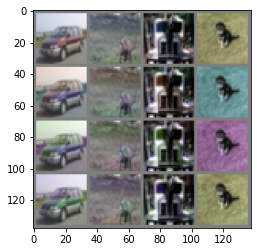

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images[:4]
BGR_images = BGR(images)
GBR_images = GBR(images)
GRB_images = GRB(images)

# show images
imshow(torchvision.utils.make_grid(torch.cat((images, BGR_images, GBR_images, GRB_images), 0), nrow=4))

Create Models

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class RGBNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 32, 5)
        self.fc1 = nn.Linear(800, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class GrayNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 32, 5)
        self.fc1 = nn.Linear(800, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class CombinedNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.toGray = nn.Conv2d(3, 1, 1)
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 32, 5)
        self.fc1 = nn.Linear(800, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.toGray(x))
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Using cpu device


In [ ]:
from torchsummary import summary
print("RGB")
summary(RGBNet().to(device), (3, 32, 32), batch_size=-1)
print("Grayscale")
summary(GrayNet().to(device), (1, 32, 32), batch_size=-1)
print("Combined")
summary(CombinedNet().to(device), (3, 32, 32), batch_size=-1)

RGB
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]           2,432
         MaxPool2d-2           [-1, 32, 14, 14]               0
            Conv2d-3           [-1, 32, 10, 10]          25,632
         MaxPool2d-4             [-1, 32, 5, 5]               0
            Linear-5                  [-1, 256]         205,056
            Linear-6                   [-1, 10]           2,570
Total params: 235,690
Trainable params: 235,690
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.27
Params size (MB): 0.90
Estimated Total Size (MB): 1.18
----------------------------------------------------------------
Grayscale
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       

In [ ]:
import torch.optim as optim

def train(dataloader, model, nr_epochs=10, process=lambda x: x, model_name="RGB"):

    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    size = len(dataloader.dataset)

    train_acc = []
    train_loss = []

    val_acc = []
    val_loss = []

    for epoch in range(nr_epochs):
      print(f"Training epoch: {epoch}")
      model.train()
      for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        X = process(X)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch % 100 == 0:
        #   loss, current = loss.item(), batch * len(X)
        #   print(f"[batch: {current:>5d}/{size:>5d}]")
      acc_train, loss_train = test(trainloader, model, loss_fn, process)
      acc_val, loss_val = test(testloader, model, loss_fn, process)
      train_acc.append(acc_train)
      train_loss.append(loss_train)
      val_acc.append(acc_val)
      val_loss.append(loss_val)

      torch.save(model, "./models/"+model_name+"_model_"+str(epoch))
    return (train_acc, train_loss, val_acc, val_loss)

def test(dataloader, model, loss_fn, process=lambda x: x, transform=lambda x: x):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            X = transform(X)
            X = process(X)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return 100*correct, test_loss      

In [ ]:
nr_epochs = 75

rgb_model = RGBNet()
rgb_model.to(device)
rgb_acc, rgb_loss, rgb_val_acc, rgb_val_loss = train(trainloader, rgb_model, nr_epochs, model_name="RGB")

gray_model = GrayNet()
gray_model.to(device)
gray_acc, gray_loss, gray_val_acc, gray_val_loss = train(trainloader, gray_model, nr_epochs, process=gray_scale, model_name="Grayscale")

combined_model = CombinedNet()
combined_model.to(device)
combined_acc, combined_loss, combined_val_acc, combined_val_loss = train(trainloader, combined_model, nr_epochs, model_name="Combined")

Training epoch: 0


KeyboardInterrupt: ignored

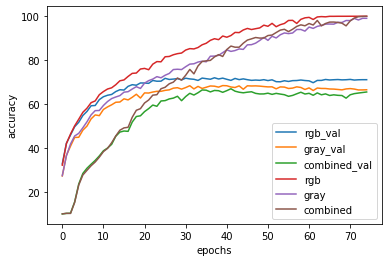

In [ ]:
plt.plot(range(nr_epochs), rgb_val_acc, label = "rgb_val")
plt.plot(range(nr_epochs), gray_val_acc, label = "gray_val")
plt.plot(range(nr_epochs), combined_val_acc, label = "combined_val")
plt.plot(range(nr_epochs), rgb_acc, label = "rgb")
plt.plot(range(nr_epochs), gray_acc, label = "gray")
plt.plot(range(nr_epochs), combined_acc, label = "combined")

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

In [ ]:
for model_nr in [19, 29, 49]:
  print(f"Model: {model_nr}")
  rgb_model = torch.load("./RGB_model_" + str(model_nr), map_location=torch.device('cpu'))
  gray_model = torch.load("./Grayscale_model_" + str(model_nr), map_location=torch.device('cpu'))
  combined_model = torch.load("./Combined_model_" + str(model_nr), map_location=torch.device('cpu')) 

  print("Test on normal")
  test(testloader, rgb_model, nn.CrossEntropyLoss())
  test(testloader, gray_model, nn.CrossEntropyLoss(), gray_scale)
  test(testloader, combined_model, nn.CrossEntropyLoss())

  print("Test on GRB processing")
  test(testloader, rgb_model, nn.CrossEntropyLoss(), transform=GRB)
  test(testloader, gray_model, nn.CrossEntropyLoss(), gray_scale, transform=GRB)
  test(testloader, combined_model, nn.CrossEntropyLoss(), transform=GRB)

  print("Test on RBG processing")
  test(testloader, rgb_model, nn.CrossEntropyLoss(), transform=RBG)
  test(testloader, gray_model, nn.CrossEntropyLoss(), gray_scale, transform=RBG)
  test(testloader, combined_model, nn.CrossEntropyLoss(), transform=RBG)

  print("Test on BGR processing")
  test(testloader, rgb_model, nn.CrossEntropyLoss(), transform=BGR)
  test(testloader, gray_model, nn.CrossEntropyLoss(), gray_scale, transform=BGR)
  test(testloader, combined_model, nn.CrossEntropyLoss(), transform=BGR)

  print("Test on GBR processing")
  test(testloader, rgb_model, nn.CrossEntropyLoss(), transform=GBR)
  test(testloader, gray_model, nn.CrossEntropyLoss(), gray_scale, transform=GBR)
  test(testloader, combined_model, nn.CrossEntropyLoss(), transform=GBR)

Model: 19
Test on normal
Test Error: 
 Accuracy: 69.6%, Avg loss: 0.879889 

Test Error: 
 Accuracy: 62.7%, Avg loss: 1.080226 

Test Error: 
 Accuracy: 54.7%, Avg loss: 1.280859 

Test on GRB processing
Test Error: 
 Accuracy: 59.0%, Avg loss: 1.279734 

Test Error: 
 Accuracy: 62.7%, Avg loss: 1.080226 

Test Error: 
 Accuracy: 54.3%, Avg loss: 1.296481 

Test on RBG processing
Test Error: 
 Accuracy: 55.9%, Avg loss: 1.321280 

Test Error: 
 Accuracy: 62.7%, Avg loss: 1.080226 

Test Error: 
 Accuracy: 54.0%, Avg loss: 1.313090 

Test on BGR processing
Test Error: 
 Accuracy: 43.8%, Avg loss: 1.816392 

Test Error: 
 Accuracy: 62.7%, Avg loss: 1.080226 

Test Error: 
 Accuracy: 49.7%, Avg loss: 1.453424 

Test on GBR processing
Test Error: 
 Accuracy: 46.7%, Avg loss: 1.688652 

Test Error: 
 Accuracy: 62.7%, Avg loss: 1.080226 

Test Error: 
 Accuracy: 51.1%, Avg loss: 1.394739 

Model: 29
Test on normal
Test Error: 
 Accuracy: 71.0%, Avg loss: 0.871348 

Test Error: 
 Accuracy: 66

In [ ]:
model_names = [
    "resnet20",
    "resnet32",
    "resnet44",
    "resnet56",
    "vgg11_bn",
    "vgg16_bn",
    "mobilenetv2_x0_5",
    "mobilenetv2_x0_75",
    "mobilenetv2_x1_0",
    "mobilenetv2_x1_4",
    "shufflenetv2_x0_5",
    "shufflenetv2_x1_0",
    "shufflenetv2_x1_5",
    "shufflenetv2_x2_0",
    "repvgg_a0",
    "repvgg_a1",
    "repvgg_a2"
]

for model_name in model_names:
  print(f"Testing of the model: {model_name}")

  model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_"+model_name, pretrained=True)

  print("Test on normal")
  test(testloader, model, nn.CrossEntropyLoss())

  print("Test on GRB processing")
  test(testloader, model, nn.CrossEntropyLoss(), transform=GRB)

  print("Test on RBG processing")
  test(testloader, model, nn.CrossEntropyLoss(), transform=RBG)

  print("Test on BGR processing")
  test(testloader, model, nn.CrossEntropyLoss(), transform=BGR)

  print("Test on GBR processing")
  test(testloader, model, nn.CrossEntropyLoss(), transform=GBR)

Testing of the model: resnet20
Test on normal


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Test Error: 
 Accuracy: 81.1%, Avg loss: 0.746166 

Test on GRB processing
Test Error: 
 Accuracy: 73.1%, Avg loss: 1.137446 

Test on RBG processing
Test Error: 
 Accuracy: 77.5%, Avg loss: 0.883749 

Test on BGR processing
Test Error: 
 Accuracy: 74.5%, Avg loss: 1.050828 

Test on GBR processing
Test Error: 
 Accuracy: 73.5%, Avg loss: 1.052466 

Testing of the model: resnet32


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar10_resnet32-ef93fc4d.pt" to /root/.cache/torch/hub/checkpoints/cifar10_resnet32-ef93fc4d.pt


  0%|          | 0.00/1.85M [00:00<?, ?B/s]

Test on normal
Test Error: 
 Accuracy: 84.8%, Avg loss: 0.696327 

Test on GRB processing
Test Error: 
 Accuracy: 78.1%, Avg loss: 1.096975 

Test on RBG processing
Test Error: 
 Accuracy: 81.3%, Avg loss: 0.860475 

Test on BGR processing
Test Error: 
 Accuracy: 79.5%, Avg loss: 0.975214 

Test on GBR processing
Test Error: 
 Accuracy: 78.6%, Avg loss: 0.989045 

Testing of the model: resnet44


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar10_resnet44-2a3cabcb.pt" to /root/.cache/torch/hub/checkpoints/cifar10_resnet44-2a3cabcb.pt


  0%|          | 0.00/2.62M [00:00<?, ?B/s]

Test on normal
Test Error: 
 Accuracy: 85.7%, Avg loss: 0.667846 

Test on GRB processing
Test Error: 
 Accuracy: 78.8%, Avg loss: 1.034862 

Test on RBG processing
Test Error: 
 Accuracy: 82.7%, Avg loss: 0.815385 

Test on BGR processing
Test Error: 
 Accuracy: 80.1%, Avg loss: 0.970508 

Test on GBR processing
Test Error: 
 Accuracy: 79.5%, Avg loss: 0.975942 

Testing of the model: resnet56


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar10_resnet56-187c023a.pt" to /root/.cache/torch/hub/checkpoints/cifar10_resnet56-187c023a.pt


  0%|          | 0.00/3.39M [00:00<?, ?B/s]

Test on normal
Test Error: 
 Accuracy: 86.5%, Avg loss: 0.630553 

Test on GRB processing
Test Error: 
 Accuracy: 77.5%, Avg loss: 1.119155 

Test on RBG processing
Test Error: 
 Accuracy: 82.1%, Avg loss: 0.838185 

Test on BGR processing
Test Error: 
 Accuracy: 80.8%, Avg loss: 0.909572 

Test on GBR processing
Test Error: 
 Accuracy: 79.1%, Avg loss: 0.985901 

Testing of the model: vgg11_bn


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/vgg/cifar10_vgg11_bn-eaeebf42.pt" to /root/.cache/torch/hub/checkpoints/cifar10_vgg11_bn-eaeebf42.pt


  0%|          | 0.00/37.3M [00:00<?, ?B/s]

Test on normal
Test Error: 
 Accuracy: 73.5%, Avg loss: 1.278463 

Test on GRB processing
Test Error: 
 Accuracy: 59.5%, Avg loss: 2.172444 

Test on RBG processing
Test Error: 
 Accuracy: 62.4%, Avg loss: 1.935356 

Test on BGR processing
Test Error: 
 Accuracy: 62.7%, Avg loss: 1.856987 

Test on GBR processing
Test Error: 
 Accuracy: 57.3%, Avg loss: 2.208328 

Testing of the model: vgg16_bn


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Test on normal
Test Error: 
 Accuracy: 82.9%, Avg loss: 0.935830 

Test on GRB processing
Test Error: 
 Accuracy: 72.4%, Avg loss: 1.545145 

Test on RBG processing
Test Error: 
 Accuracy: 76.2%, Avg loss: 1.264966 

Test on BGR processing
Test Error: 
 Accuracy: 74.9%, Avg loss: 1.388834 

Test on GBR processing
Test Error: 
 Accuracy: 71.2%, Avg loss: 1.585273 

Testing of the model: mobilenetv2_x0_5


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/mobilenetv2/cifar10_mobilenetv2_x0_5-ca14ced9.pt" to /root/.cache/torch/hub/checkpoints/cifar10_mobilenetv2_x0_5-ca14ced9.pt


  0%|          | 0.00/2.85M [00:00<?, ?B/s]

Test on normal
Test Error: 
 Accuracy: 79.5%, Avg loss: 0.870453 

Test on GRB processing
Test Error: 
 Accuracy: 69.6%, Avg loss: 1.447810 

Test on RBG processing
Test Error: 
 Accuracy: 73.5%, Avg loss: 1.137349 

Test on BGR processing
Test Error: 
 Accuracy: 72.0%, Avg loss: 1.263622 

Test on GBR processing
Test Error: 
 Accuracy: 69.5%, Avg loss: 1.354073 

Testing of the model: mobilenetv2_x0_75


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/mobilenetv2/cifar10_mobilenetv2_x0_75-a53c314e.pt" to /root/.cache/torch/hub/checkpoints/cifar10_mobilenetv2_x0_75-a53c314e.pt


  0%|          | 0.00/5.42M [00:00<?, ?B/s]

Test on normal
Test Error: 
 Accuracy: 82.0%, Avg loss: 0.803513 

Test on GRB processing
Test Error: 
 Accuracy: 74.2%, Avg loss: 1.167940 

Test on RBG processing
Test Error: 
 Accuracy: 77.5%, Avg loss: 1.000674 

Test on BGR processing
Test Error: 
 Accuracy: 75.6%, Avg loss: 1.127447 

Test on GBR processing
Test Error: 
 Accuracy: 74.2%, Avg loss: 1.166200 

Testing of the model: mobilenetv2_x1_0


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/mobilenetv2/cifar10_mobilenetv2_x1_0-fe6a5b48.pt" to /root/.cache/torch/hub/checkpoints/cifar10_mobilenetv2_x1_0-fe6a5b48.pt


  0%|          | 0.00/8.77M [00:00<?, ?B/s]

Test on normal
Test Error: 
 Accuracy: 84.2%, Avg loss: 0.695668 

Test on GRB processing
Test Error: 
 Accuracy: 75.4%, Avg loss: 1.078438 

Test on RBG processing
Test Error: 
 Accuracy: 79.5%, Avg loss: 0.895651 

Test on BGR processing
Test Error: 
 Accuracy: 78.0%, Avg loss: 0.989556 

Test on GBR processing
Test Error: 
 Accuracy: 76.1%, Avg loss: 1.049946 

Testing of the model: mobilenetv2_x1_4


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/mobilenetv2/cifar10_mobilenetv2_x1_4-3bbbd6e2.pt" to /root/.cache/torch/hub/checkpoints/cifar10_mobilenetv2_x1_4-3bbbd6e2.pt


  0%|          | 0.00/16.8M [00:00<?, ?B/s]

Test on normal
Test Error: 
 Accuracy: 84.1%, Avg loss: 0.712084 

Test on GRB processing
Test Error: 
 Accuracy: 76.0%, Avg loss: 1.098709 

Test on RBG processing
Test Error: 
 Accuracy: 78.7%, Avg loss: 0.961049 

Test on BGR processing
Test Error: 
 Accuracy: 78.9%, Avg loss: 0.988236 

Test on GBR processing
Test Error: 
 Accuracy: 75.2%, Avg loss: 1.109021 

Testing of the model: shufflenetv2_x0_5


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/shufflenetv2/cifar10_shufflenetv2_x0_5-1308b4e9.pt" to /root/.cache/torch/hub/checkpoints/cifar10_shufflenetv2_x0_5-1308b4e9.pt


  0%|          | 0.00/1.48M [00:00<?, ?B/s]

Test on normal
Test Error: 
 Accuracy: 73.2%, Avg loss: 1.069938 

Test on GRB processing
Test Error: 
 Accuracy: 64.0%, Avg loss: 1.582991 

Test on RBG processing
Test Error: 
 Accuracy: 66.6%, Avg loss: 1.324848 

Test on BGR processing
Test Error: 
 Accuracy: 64.1%, Avg loss: 1.510673 

Test on GBR processing
Test Error: 
 Accuracy: 63.0%, Avg loss: 1.514562 

Testing of the model: shufflenetv2_x1_0


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/shufflenetv2/cifar10_shufflenetv2_x1_0-98807be3.pt" to /root/.cache/torch/hub/checkpoints/cifar10_shufflenetv2_x1_0-98807be3.pt


  0%|          | 0.00/4.99M [00:00<?, ?B/s]

Test on normal
Test Error: 
 Accuracy: 80.7%, Avg loss: 0.839506 

Test on GRB processing
Test Error: 
 Accuracy: 69.8%, Avg loss: 1.458873 

Test on RBG processing
Test Error: 
 Accuracy: 74.6%, Avg loss: 1.141790 

Test on BGR processing
Test Error: 
 Accuracy: 72.7%, Avg loss: 1.262029 

Test on GBR processing
Test Error: 
 Accuracy: 69.9%, Avg loss: 1.374450 

Testing of the model: shufflenetv2_x1_5


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/shufflenetv2/cifar10_shufflenetv2_x1_5-296694dd.pt" to /root/.cache/torch/hub/checkpoints/cifar10_shufflenetv2_x1_5-296694dd.pt


  0%|          | 0.00/9.69M [00:00<?, ?B/s]

Test on normal
Test Error: 
 Accuracy: 81.7%, Avg loss: 0.782431 

Test on GRB processing
Test Error: 
 Accuracy: 70.7%, Avg loss: 1.351613 

Test on RBG processing
Test Error: 
 Accuracy: 75.2%, Avg loss: 1.096752 

Test on BGR processing
Test Error: 
 Accuracy: 74.9%, Avg loss: 1.099311 

Test on GBR processing
Test Error: 
 Accuracy: 71.7%, Avg loss: 1.266413 

Testing of the model: shufflenetv2_x2_0


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/shufflenetv2/cifar10_shufflenetv2_x2_0-ec31611c.pt" to /root/.cache/torch/hub/checkpoints/cifar10_shufflenetv2_x2_0-ec31611c.pt


  0%|          | 0.00/20.7M [00:00<?, ?B/s]

Test on normal
Test Error: 
 Accuracy: 82.2%, Avg loss: 0.791967 

Test on GRB processing
Test Error: 
 Accuracy: 72.4%, Avg loss: 1.241669 

Test on RBG processing
Test Error: 
 Accuracy: 75.5%, Avg loss: 1.065399 

Test on BGR processing
Test Error: 
 Accuracy: 75.0%, Avg loss: 1.171530 

Test on GBR processing
Test Error: 
 Accuracy: 72.6%, Avg loss: 1.218045 

Testing of the model: repvgg_a0


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/repvgg/cifar10_repvgg_a0-ef08a50e.pt" to /root/.cache/torch/hub/checkpoints/cifar10_repvgg_a0-ef08a50e.pt


  0%|          | 0.00/30.1M [00:00<?, ?B/s]

Test on normal
Test Error: 
 Accuracy: 84.6%, Avg loss: 0.736769 

Test on GRB processing
Test Error: 
 Accuracy: 74.4%, Avg loss: 1.293633 

Test on RBG processing
Test Error: 
 Accuracy: 78.4%, Avg loss: 1.029952 

Test on BGR processing
Test Error: 
 Accuracy: 77.9%, Avg loss: 1.053185 

Test on GBR processing
Test Error: 
 Accuracy: 75.2%, Avg loss: 1.189020 

Testing of the model: repvgg_a1


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/repvgg/cifar10_repvgg_a1-38d2431b.pt" to /root/.cache/torch/hub/checkpoints/cifar10_repvgg_a1-38d2431b.pt


  0%|          | 0.00/49.2M [00:00<?, ?B/s]

Test on normal
Test Error: 
 Accuracy: 84.5%, Avg loss: 0.715722 

Test on GRB processing
Test Error: 
 Accuracy: 78.1%, Avg loss: 1.004647 

Test on RBG processing
Test Error: 
 Accuracy: 81.0%, Avg loss: 0.855922 

Test on BGR processing
Test Error: 
 Accuracy: 78.3%, Avg loss: 1.050657 

Test on GBR processing
Test Error: 
 Accuracy: 78.5%, Avg loss: 0.980892 

Testing of the model: repvgg_a2


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/repvgg/cifar10_repvgg_a2-09488915.pt" to /root/.cache/torch/hub/checkpoints/cifar10_repvgg_a2-09488915.pt


  0%|          | 0.00/103M [00:00<?, ?B/s]

Test on normal
Test Error: 
 Accuracy: 86.4%, Avg loss: 0.618530 

Test on GRB processing
Test Error: 
 Accuracy: 78.5%, Avg loss: 1.038061 

Test on RBG processing
Test Error: 
 Accuracy: 81.7%, Avg loss: 0.833923 

Test on BGR processing
Test Error: 
 Accuracy: 80.6%, Avg loss: 0.890925 

Test on GBR processing
Test Error: 
 Accuracy: 77.9%, Avg loss: 1.017621 

